In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

### Mecab 설치

In [2]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git


Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [3]:
ls

drive/  Mecab-ko-for-Google-Colab/  sample_data/


In [5]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab


In [6]:
ls

images/                                    LICENSE
install_mecab-ko_on_colab190912.sh         README.md
install_mecab-ko_on_colab_light_210108.sh


In [ ]:
! bash install_mecab-ko_on_colab190912.sh

In [1]:
# mecab 테스트하기
from konlpy.tag import Mecab
mecab = Mecab()
text = u"""colab에서 mecab테스트 중입니다!"""
mecab.morphs(text)

['colab', '에서', 'mecab', '테스트', '중', '입니다', '!']

### 필요한 라이브러리들 설치
- keras/tensorflow
- numpy, pandas, matplotlib
- sklearn

In [ ]:
!pip install tensorflow
!pip install keras


In [2]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.3.0
1.15.0


In [12]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

#### 라이브러리 import

In [3]:

import os, json, glob, sys
import pandas as pd
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, Input, Conv1D, MaxPooling1D, GlobalMaxPool1D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

from konlpy.tag import Mecab
mecab = Mecab()


#### Dataset 불러오기

In [4]:
path = "./web/"
file_list = os.listdir(path)
names = [file[:-4] for file in file_list]
names

['곤충',
 '행정_기관_단체',
 '한국_철학_윤리',
 '기타종교',
 '커피_차',
 '클래식',
 '영화',
 '군사',
 '부동산',
 '게임',
 '만화',
 '사회복지',
 '음악용어',
 '직업',
 '아프리카',
 '독일문학',
 '무역',
 '건축물',
 '육아',
 '북아메리카',
 '건설_토목',
 '농학',
 '프랑스문학',
 '영미문학',
 '중동_역사_문화',
 '한국_민속',
 '무기',
 '속담',
 '기계_자동차_금속',
 '국제기구',
 '외교',
 '이슬람교',
 '패션',
 '경제',
 '댄스_무용',
 '동물',
 '주류',
 '한국_역사_문화',
 '생명과학',
 '호텔',
 '법',
 '북한문학',
 '아시아',
 '남아메리카',
 '헤어',
 '서양_철학_윤리',
 '불교',
 '정치',
 '재료',
 '교양영어사전',
 '명화',
 '심리',
 '화학',
 '수학',
 '물리학',
 '세계_역사_문화',
 '세계음식',
 '중국문학',
 '미술',
 '한국음식',
 '의학',
 '환경',
 '색채',
 '드라마',
 '한국문학',
 '아시아_역사_문화',
 '교양_인문',
 '질병',
 '천문학',
 '뮤지컬',
 '식물',
 '인테리어',
 '오세아니아',
 '전시관',
 '악기',
 '일본문학',
 '약학',
 'IT',
 '동양_철학_윤리',
 '회계_세무',
 '지구과학',
 '음악사',
 '공예',
 '유럽',
 '세계문학',
 '한국',
 '유럽_역사_문화',
 '바둑',
 '기독교',
 '중동',
 '기업_브랜드']

In [5]:
df = pd.DataFrame(columns=['topic', 'sub_topic', 'contents', 'label'])

idx = 0
topic_index = dict()
for name in names:
    temp_df = pd.read_csv(path+"/"+name+'.csv', encoding= 'cp949', names=['url', 'sub_topic', 'contents'])
    len_ = len(temp_df)
    temp_df['topic'] = [name]*len_
    temp_df['label'] = [idx]*len_
    temp_df = temp_df.loc[:, ['topic', 'sub_topic', 'contents','label']]
    df = pd.concat([df, temp_df])
    topic_index[name] = idx
    idx += 1
    del temp_df
df

,topic,sub_topic,contents,label
0,곤충,소금쟁이,몸 길이는 11 16mm이며 몸은 흑갈색 또는 검은색 바탕에 갈색 무늬를 띠고 은빛...,0
1,곤충,물방개,몸 길이는 34 42mm이며 몸은 약한 녹색 광택을 띠는 흑색인데 몸의 가장자리는 ...,0
2,곤충,쌀바구미,몸 길이는 3 4mm이고 흑갈색으로서 앞가슴의 등면과 앞날개 위에 원형의 작은 점...,0
3,곤충,동애등에,몸 길이는 13 20mm이며 전체적인 색상은 흑색이다. 얼굴은 흑갈색으로 길이가 매...,0
4,곤충,거저리,몸 길이는 13 17mm이며 몸은 흑갈색이고 광택이 있으며 길쭉한 모양이다. 앞가...,0
...,...,...,...,...
3843,기업_브랜드,패러마운트커뮤니케이션스,1994년 미디어그룹 비아콤에 합병된 미디어 커뮤니케이션회사,90
3844,기업_브랜드,대조선저마제사회사,삼과 모시를 합사하여 외국에 수출하기 위해 1897년 설립된 회사,90
3845,기업_브랜드,삼정사,조선 왕실이 1899년 세운 최초의 인삼전매회사다.,90
3846,기업_브랜드,핀시데르,자동차산업에 필요한 평면철강제품을 생산하는 데 주력해온 이탈리아의 대형 회사,90


In [6]:
# 데이터 섞기
df_shuffled=df.sample(frac=1).reset_index(drop=True)
df_shuffled.head()

,topic,sub_topic,contents,label
0,군사,전력구조,전투력의 수단을 가장 효과적으로 구성함으로서 전투효율성을 극대화시키려는 작전적 기능...,7
1,식물,제주솔밭버섯,중앙이 오목해서 깔때기 모양으로 됨 조직이 약간 질김,70
2,수학,괴델수,수리논리학은 논리를 수학의 방법을 써서 다룬다. 논리학의 대상 즉 기호 명제 증명 ...,53
3,불교,전주,불전 을 맡아서 돌보는 직책 또는 그 일을 하는 승려.,46
4,세계_역사_문화,빌헬름2세,20세기 초 유럽은 세계를 지배하고 그 영화는 영원히 계속되는 듯싶었다. 그러나 한...,55


In [7]:
# 데이터 셋 크기
len(df)

386367

#### Data preprocessing

In [8]:
# 데이터 셋을 input, output구별
X = df_shuffled.loc[:, 'contents'].values
Y = df_shuffled.loc[:, 'label'].values

In [9]:
topic_index

{'곤충': 0,
 '행정_기관_단체': 1,
 '한국_철학_윤리': 2,
 '기타종교': 3,
 '커피_차': 4,
 '클래식': 5,
 '영화': 6,
 '군사': 7,
 '부동산': 8,
 '게임': 9,
 '만화': 10,
 '사회복지': 11,
 '음악용어': 12,
 '직업': 13,
 '아프리카': 14,
 '독일문학': 15,
 '무역': 16,
 '건축물': 17,
 '육아': 18,
 '북아메리카': 19,
 '건설_토목': 20,
 '농학': 21,
 '프랑스문학': 22,
 '영미문학': 23,
 '중동_역사_문화': 24,
 '한국_민속': 25,
 '무기': 26,
 '속담': 27,
 '기계_자동차_금속': 28,
 '국제기구': 29,
 '외교': 30,
 '이슬람교': 31,
 '패션': 32,
 '경제': 33,
 '댄스_무용': 34,
 '동물': 35,
 '주류': 36,
 '한국_역사_문화': 37,
 '생명과학': 38,
 '호텔': 39,
 '법': 40,
 '북한문학': 41,
 '아시아': 42,
 '남아메리카': 43,
 '헤어': 44,
 '서양_철학_윤리': 45,
 '불교': 46,
 '정치': 47,
 '재료': 48,
 '교양영어사전': 49,
 '명화': 50,
 '심리': 51,
 '화학': 52,
 '수학': 53,
 '물리학': 54,
 '세계_역사_문화': 55,
 '세계음식': 56,
 '중국문학': 57,
 '미술': 58,
 '한국음식': 59,
 '의학': 60,
 '환경': 61,
 '색채': 62,
 '드라마': 63,
 '한국문학': 64,
 '아시아_역사_문화': 65,
 '교양_인문': 66,
 '질병': 67,
 '천문학': 68,
 '뮤지컬': 69,
 '식물': 70,
 '인테리어': 71,
 '오세아니아': 72,
 '전시관': 73,
 '악기': 74,
 '일본문학': 75,
 '약학': 76,
 'IT': 77,
 '동양_철학_윤리': 78,
 '회계_세무': 79,
 

In [10]:
unique_elements, counts_elements = np.unique(Y, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
  27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
  51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
  75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
 [1522 1525 1006 4545 2837 1001 1499 6516 2721 661 4854 4665 5588 8052
  1346 942 1893 2826 392 1520 10005 9095 1009 637 2527 6098 5444 282 7652
  357 1278 75 9447 3118 3275 389 9737 9786 9396 1706 3858 488 9963 2576
  341 9960 9294 4504 1072 1003 9690 9628 9875 2073 2449 7559 6413 9050
  6403 6681 9406 3268 1417 594 9442 2439 3564 4622 502 318 5834 1711 369
  2588 1375 1045 10005 7398 3811 1542 4418 1265 949 9922 7276 9991 4231
  2104 9530 1479 3848]]


<BarContainer object of 91 artists>

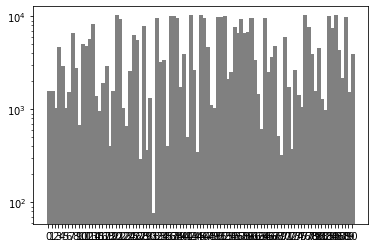

In [11]:
plt.bar(unique_elements, counts_elements, width=0.3, align='edge', color="blue",
        edgecolor="gray", linewidth=3, tick_label=unique_elements, log=True)

In [12]:
print(len(X))
print(len(Y))

386367
386367


In [18]:
# stop word 불러오기
path ='./korean_stopwords.txt'
f = open(path, 'r', encoding='utf-8')
stop_words = []
while True:
    line = f.readline()
    if not line: break
    stop_words.append(line.split()[0])
f.close()

In [19]:
stop_words[:5]

['이', '있', '하', '것', '들']

In [20]:
new_X = []
delete_Y_idxs = []
for idx in range(len(X)):
  # 1. 토큰화
  temp = mecab.morphs(X[idx])
  # 2. 불용어 제거
  temp = [i for i in temp if i not in stop_words and i != '.']
  if temp:
      new_X.append(temp)
  else:
    delete_Y_idxs.append(idx)


In [21]:
print(len(new_X))
print(len(X))
print(len(delete_Y_idxs))


385030
386367
1337


In [22]:
# 필요없는 부분 제거
new_Y = np.delete(Y, delete_Y_idxs)
print(len(new_X))
print(len(X))
print(len(new_Y))
print(len(Y))

385030
386367
385030
386367


In [23]:
new_X[4]

['20',
 '세기',
 '초',
 '유럽',
 '은',
 '세계',
 '를',
 '지배',
 '고',
 '영화',
 '는',
 '영원히',
 '계속',
 '는',
 '듯',
 '었',
 '다',
 '발',
 '의',
 '총성',
 '꿈',
 '을',
 '산산조각',
 '냈',
 '다',
 '비스마르크',
 '는',
 '독일',
 '을',
 '통일',
 '할',
 '까지',
 '은',
 '전쟁',
 '을',
 '치렀',
 '다',
 '통일',
 '후',
 '에',
 '는',
 '마치',
 '딴',
 '처럼',
 '평화',
 '애호가',
 '었',
 '다',
 '러시아',
 '와',
 '터키',
 '의',
 '전쟁',
 '원인',
 '어',
 '유럽',
 '에',
 '대전',
 '일어날',
 '기미',
 '자',
 '소동',
 '을',
 '진정',
 '기',
 '위해',
 '활동',
 '여',
 '마침내',
 '베를린',
 '국제',
 '회의',
 '에서',
 '전쟁',
 '을',
 '저지',
 '시켰',
 '다',
 '프랑스',
 '를',
 '꼼짝',
 '못',
 '게',
 '려고',
 '국가',
 '과',
 '손',
 '을',
 '잡',
 '았',
 '다',
 '외교',
 '에서',
 '듯',
 '대성공',
 '을',
 '거둔',
 '비스마르크',
 '도',
 '내정',
 '에서',
 '는',
 '실패',
 '했',
 '다',
 '가톨릭',
 '교회',
 '와',
 '사회주의',
 '운동',
 '모두',
 '를',
 '압박',
 '실패',
 '의',
 '원인',
 '었',
 '고',
 '는',
 '점차',
 '국내',
 '의',
 '지지',
 '기반',
 '을',
 '잃',
 '어',
 '갔',
 '다',
 '빌헬름',
 '1',
 '세',
 '타계',
 '후',
 '새',
 '황제',
 '프리드리히',
 '3',
 '세',
 '도',
 '3',
 '개월',
 '만',
 '에',
 '죽',
 '고',
 '았',
 '다',
 '빌헬름',
 '1',
 '세',

In [24]:
# X 정수 encoding하기
max_word =250000
max_len = 1000 #max_len = 500

tok = Tokenizer(num_words = max_word)
tok.fit_on_texts(new_X)
sequences = tok.texts_to_sequences(new_X)
print(len(tok.word_index))

418294


각 기사의 단어 수가 제각각 다르므로 이를 동일하게 맞춰야 한다.
이때는 다음과 같이 데이터 전처리 함수 sequence()를 이용한다.

In [25]:
sequences_matrix  = sequence.pad_sequences(sequences, maxlen=max_len)
print(sequences_matrix)
print(len(sequences_matrix[0]))

[[    0     0     0 ...  1373   932  3139]
 [    0     0     0 ...   293   636 73744]
 [    0     0     0 ...  2082    18 10068]
 ...
 [    0     0     0 ...  3129    23     5]
 [    0     0     0 ...     1   149   112]
 [    0     0     0 ...     4   346    20]]
1000


In [26]:
type(sequences_matrix)

numpy.ndarray

In [27]:
type(new_Y)

numpy.ndarray

In [28]:
print(len(sequences_matrix))

385030


In [29]:
# new_Y 데이터에 원-핫 인코딩 처리를 하여 데이터 전처리 과정을 마친다.
nb_classes = len(set(new_Y))
print(nb_classes)
y = np_utils.to_categorical(new_Y, nb_classes)


91


In [30]:
print(y[100])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(sequences_matrix, y, test_size=0.2)

In [32]:
print(X_train.shape)
print(y_train.shape)

(308024, 1000)
(308024, 91)


In [33]:
print(X_test.shape)
print(y_test.shape)

(77006, 1000)
(77006, 91)


##### training set X : 308024, 1000
##### training set Y : 308024, 91

##### training set X : 77006, 1000
##### training set Y : 77006, 91

### Model 설계 및 훈련

In [34]:
model = Sequential()

model.add(Embedding(max_word, 64, input_length=max_len))
model.add(LSTM(60, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [36]:
model_dir = './model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path = model_dir + "/Naver_dict_lstm.h5"

In [37]:
model_path

'./model/Naver_dict_lstm.h5'

In [48]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 64)          16000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 60)          30000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 91)               

In [50]:
history = model.fit(X_train, y_train, batch_size=256, epochs=50, callbacks=[es, mc], validation_split=0.2)

Train on 246419 samples, validate on 61605 samples
Epoch 1/50
246419/246419 [==============================] - 796s 3ms/step - loss: 1.8049 - accuracy: 0.5184 - val_loss: 1.3669 - val_accuracy: 0.6373

Epoch 00001: val_accuracy improved from -inf to 0.63727, saving model to ./model/Naver_dict_lstm.h5
Epoch 2/50
246419/246419 [==============================] - 793s 3ms/step - loss: 1.3993 - accuracy: 0.6157 - val_loss: 1.2513 - val_accuracy: 0.6695

Epoch 00002: val_accuracy improved from 0.63727 to 0.66946, saving model to ./model/Naver_dict_lstm.h5
Epoch 3/50
246419/246419 [==============================] - 792s 3ms/step - loss: 1.1888 - accuracy: 0.6662 - val_loss: 1.1768 - val_accuracy: 0.6910

Epoch 00003: val_accuracy improved from 0.66946 to 0.69097, saving model to ./model/Naver_dict_lstm.h5
Epoch 4/50
246419/246419 [==============================] - 792s 3ms/step - loss: 1.0272 - accuracy: 0.7065 - val_loss: 1.2046 - val_accuracy: 0.7011

Epoch 00004: val_accuracy improved from

In [51]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

77006/77006 [==============================] - 120s 2ms/step
정확도 : 0.7222


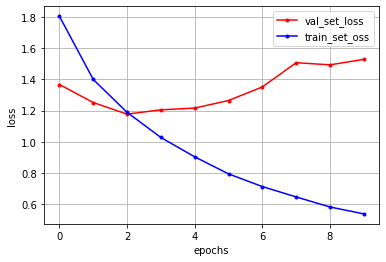

In [55]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

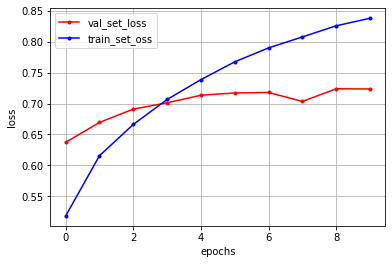

In [58]:
y_vloss = history.history['val_accuracy']
y_loss = history.history['accuracy']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
str = ['''이번 시간에는 문화의 정의와 구분 방식, 문화의 유동성과 통번역과의 관계를 학습하겠습니다.
또 통번역의 역사적인 발전과 중요성을 세계사와 국내 역사의 관점에서 살펴본 다음,
통번역과 국가경쟁력, 또 통번역과 개개인의 경쟁력 간의 관계를 알아보겠습니다.
그럼 우리가 함께 살펴볼 첫 번째 개념이 문화입니다. 이 어휘는 실생활에서 우리가 너무 흔하게 접하기 때문에 의미를 크게 깊이 생각하지 않고 사용하는 어휘 가운데 하나입니다.
우리가 대체로 한국문화, 미국문화, 중국문화와 같이 특정 집단 사람들이 공유하는 특징적인 삶의 방식이나 지식을 가리키는 데 사용하죠.
여기에는 언어, 정치, 경제, 종교, 예술 같은 것은 물론이고 음식이나 혼례방식, 장례방식 같은 사회적인 관습도 포함됩니다.
학자들은 가시적으로 볼 수 없는 정신이나 가치를 문화라고 부르는 데 비해서 건축이나 예술, 테크놀로지 같은 것은 문명으로 구분하는 경향이 있습니다.
그러면 문화라는 단어의 어원은 어디에 있을까요? 문화를 뜻하는 영어 어휘는 ‘culture’인데 이 어휘의 어원이 라틴어의 ‘colere’입니다. 즉, 땅을 돌보고 길러낸다는 의미죠.
이렇게 볼 때 문화라는 것은 인간이 발 디디고 생활하는 환경을 좀 더 좋게 바꿔나가는 모든 과정 또는 그것의 결과물을 가리킨다고 생각할 수 있겠습니다.
문화의 특징은 크게 두 가지인데, 첫 번째로는 특정 집단과 다른 집단을 구분 지어주는 역할을 한다는 것.
그리고 두 번째로는 특정 집단의 가치와 사고방식을 집단적으로 학습하는 과정. 곧 사회화를 통해서 구성원들이 공유하게 된다는 점입니다.
우리가 문화를 다양한 방식으로 구분할 수 있는데요. 고대문명의 발상지를 기준으로 할 때는 이집트문명, 갠지스문명, 메소포타미아문명 이렇게 구분하기도 하고요.
아시아문화, 유럽문화와 같이 문화가 분포하는 지리적인 특성이나 인종에 따라 구분하기도 합니다.
또 향유주체, 즉 문화를 누리는 사람이 누군가에 따라서 대중문화냐, 고급문화냐를 구분하거나 조직문화냐, 개인 문화냐와 같이 다양한 관점에 따라 분류하기도 합니다.
여기에서 주목할 것은 문화의 속성이 끊임없는 변화와 유동성이라는 거죠.
학자들은 문화가 단 한 번도 고정되어 있거나 정형화된 채로 머물러 있지 않고 본질적으로 끊임없이 변화한다고 강조합니다. 
''']
sequences_6m = tok.texts_to_sequences(str)
print(sequences_6m)
sequences_matrix_6m = sequence.pad_sequences(sequences_6m, maxlen=500)
model.predict_classes(sequences_matrix_6m)